# Loading images and matching them to metadata

In [1]:
#@title Imports and function definitions


# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2022-04-12 13:29:49.620924: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1
The following GPU devices are available: /device:GPU:0


2022-04-12 13:29:54.186169: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 13:29:54.193727: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-12 13:29:54.627492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.93GiB deviceMemoryBandwidth: 313.37GiB/s
2022-04-12 13:29:54.629506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock

In [2]:
# adds scripts/ and src/ folder: so you can import scripts/functions across project steps
import sys 
sys.path.append("../../src")
sys.path.append("../../scripts")

from os import listdir
from os import path

import pandas as pd
from tqdm.notebook import tqdm

from data_filepaths import image_folders, portraits_csv, images_with_boxes_path

## Linking portraits' metadata with their path

#### Loading portraits' metadata

In [3]:
portraits = pd.read_csv(portraits_csv)
portraits.head()

,Unnamed: 0,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename,correcteddate
0,70345,Masaccio,1425,portrait,548.0,800.0,116190.0,wikiart,Early Renaissance,Portrait of a Young Man,train_only,True,34161.jpg,1425.0
1,20989,Masaccio,1425,portrait,999.0,1300.0,899549.0,wikiart,Early Renaissance,Portrait of a Young Woman,train_only,True,80100.jpg,1425.0
2,12749,Robert Campin,c.1430,portrait,1256.0,1857.0,219654.0,wikiart,Northern Renaissance,Portrait of a Woman,test_only,False,85550.jpg,1430.0
3,2904,Robert Campin,c.1430,portrait,2024.0,3019.0,416418.0,wikiart,Northern Renaissance,Portrait of a Man,test_only,False,2662.jpg,1430.0
4,47846,Jan van Eyck,1432,portrait,502.0,1451.0,137626.0,wikiart,Northern Renaissance,"Isabella Borluut, panel from the Ghent Altarpiece",train_and_test,True,66905.jpg,1432.0


#### Getting images paths

In [4]:
image_folder = image_folders[0]
train0 = listdir(image_folder)
train0 = train0#[0:10] # SMALL SELECTION

image_paths = pd.DataFrame({
    "new_filename":train0,
    "path": [path.join(image_folder, n) for n in train0]
})

image_paths

,new_filename,path
0,93571.jpg,../../data/kaggle_painters_by_numbers/train/93...
1,90123.jpg,../../data/kaggle_painters_by_numbers/train/90...
2,71660.jpg,../../data/kaggle_painters_by_numbers/train/71...
3,11898.jpg,../../data/kaggle_painters_by_numbers/train/11...
4,73354.jpg,../../data/kaggle_painters_by_numbers/train/73...
...,...,...
79428,46349.jpg,../../data/kaggle_painters_by_numbers/train/46...
79429,10051.jpg,../../data/kaggle_painters_by_numbers/train/10...
79430,12831.jpg,../../data/kaggle_painters_by_numbers/train/12...
79431,12678.jpg,../../data/kaggle_painters_by_numbers/train/12...


In [5]:
portraits_path = image_paths.merge(portraits, on = 'new_filename', how = 'inner')
portraits_path.shape

(12926, 15)

# Object detection:


In [6]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" # model ssd+mobilenet V2: small and fast.
#module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" # model FasterRCNN+InceptionResNet V2: higher accuracy,
detector = hub.load(module_handle).signatures['default']



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2022-04-12 13:30:07.990072: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-12 13:30:07.990983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.93GiB deviceMemoryBandwidth: 313.37GiB/s
2022-04-12 13:30:07.992041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.93GiB deviceMemoryBandwidth: 313.37GiB/s
2022-04-12 13:30:07.992099: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-12 13:30:07.992169: I tensorflow/st

In [7]:
IMAGE_RESIZE_SHAPE = 2* [256]

def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def load_and_resize_image(path, new_width=IMAGE_RESIZE_SHAPE[0], new_height=IMAGE_RESIZE_SHAPE[1],
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  pil_image = Image.open(path)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image, image_pil

In [8]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [26]:
def format_detection_results(result):
    formatted_result =  result.copy()
    for k,v in result.items():
        formatted_result
    # dict_keys(['detection_class_entities', 'detection_scores', 'detection_boxes', 'detection_class_names', 'detection_class_labels'])
    for i, col in enumerate(["x0", "y0", "x1", "y1"]):
        formatted_result[col] = [box[i] for box in formatted_result["detection_boxes"]]
    del formatted_result["detection_boxes"]
    del formatted_result["detection_class_names"]
    return pd.DataFrame(formatted_result)



In [9]:
def run_detector(detector, path, display=True):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes, image_with_boxes_pil = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  if display:
    display_image(image_with_boxes)
  return image_with_boxes_pil, format_detection_results(result)

In [10]:
#for image_path in image_paths.path:
#    run_detector(detector, image_path)

In [11]:
portraits_path.path[0]

'../../data/kaggle_painters_by_numbers/train/50598.jpg'

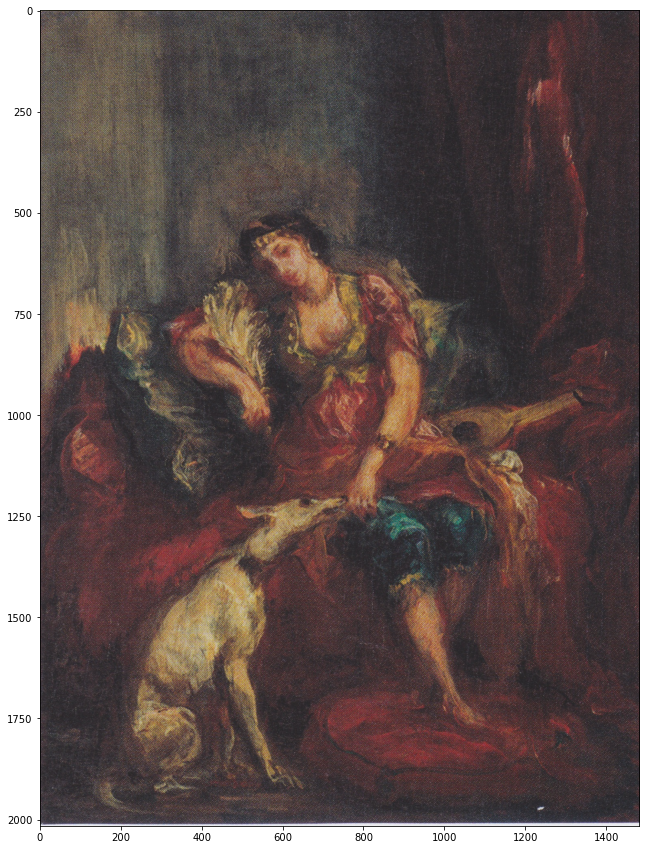

In [12]:
image = load_img(portraits_path.path[0])
display_image(image)


Image downloaded to /scratch/ddupertu/.pipenv_tmpdir/tmpg5hvpezv.jpg.


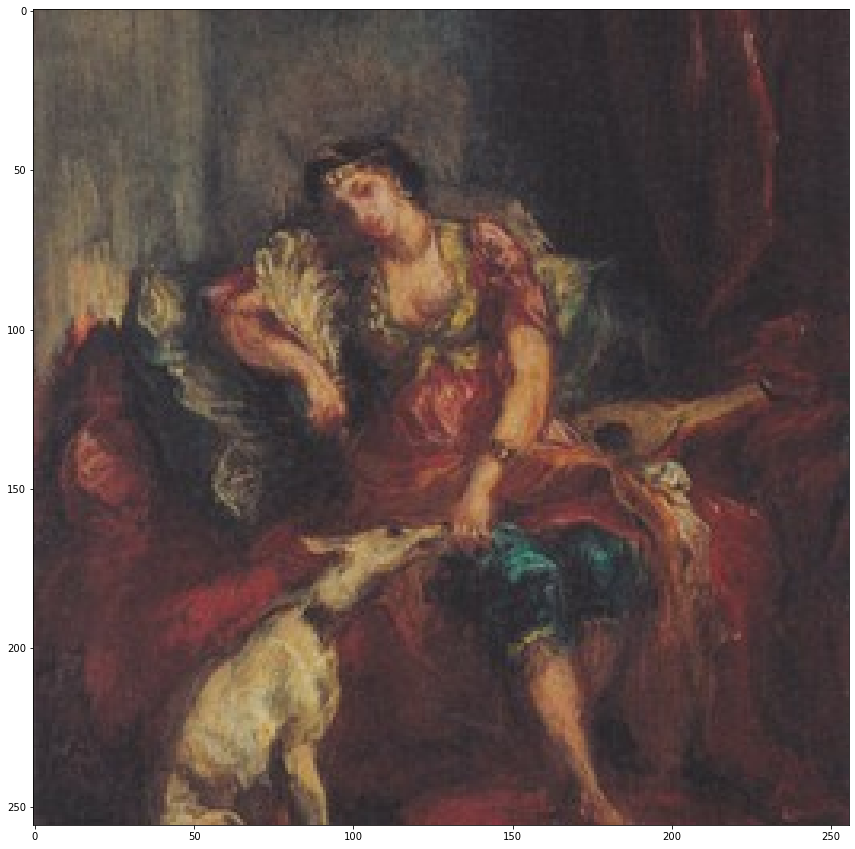

In [13]:

resized_image_path = load_and_resize_image(portraits_path.path[0])
resized_image = load_img(resized_image_path)
display_image(resized_image)

2022-04-12 13:30:49.158705: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-04-12 13:30:51.272107: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-12 13:30:51.583147: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 799.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-12 13:30:51.728171: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 918.27MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-12 13:30:51.777155: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bf

Found 100 objects.
Inference time:  21.284510612487793
Font not found, using default font.


(<PIL.Image.Image image mode=RGB size=256x256 at 0x7F41997F37F0>,
 {'detection_class_entities': array([b'Person', b'Human face', b'Clothing', b'Human face', b'Clothing',
         b'Clothing', b'Clothing', b'Clothing', b'Person', b'Man', b'Tree',
         b'Clothing', b'Tree', b'Clothing', b'Clothing', b'Clothing',
         b'Clothing', b'Human face', b'Clothing', b'Clothing', b'Tree',
         b'Clothing', b'Dog', b'Woman', b'Dog', b'Clothing', b'Clothing',
         b'Human face', b'Clothing', b'Clothing', b'Clothing', b'Clothing',
         b'Human face', b'Clothing', b'Clothing', b'Clothing', b'Clothing',
         b'Clothing', b'Clothing', b'Clothing', b'Clothing', b'Tree',
         b'Clothing', b'Clothing', b'Clothing', b'Clothing', b'Human face',
         b'Person', b'Clothing', b'Clothing', b'Human face', b'Clothing',
         b'Clothing', b'Clothing', b'Tree', b'Clothing', b'Clothing',
         b'Human face', b'Clothing', b'Human face', b'Clothing',
         b'Clothing', b'Clothin

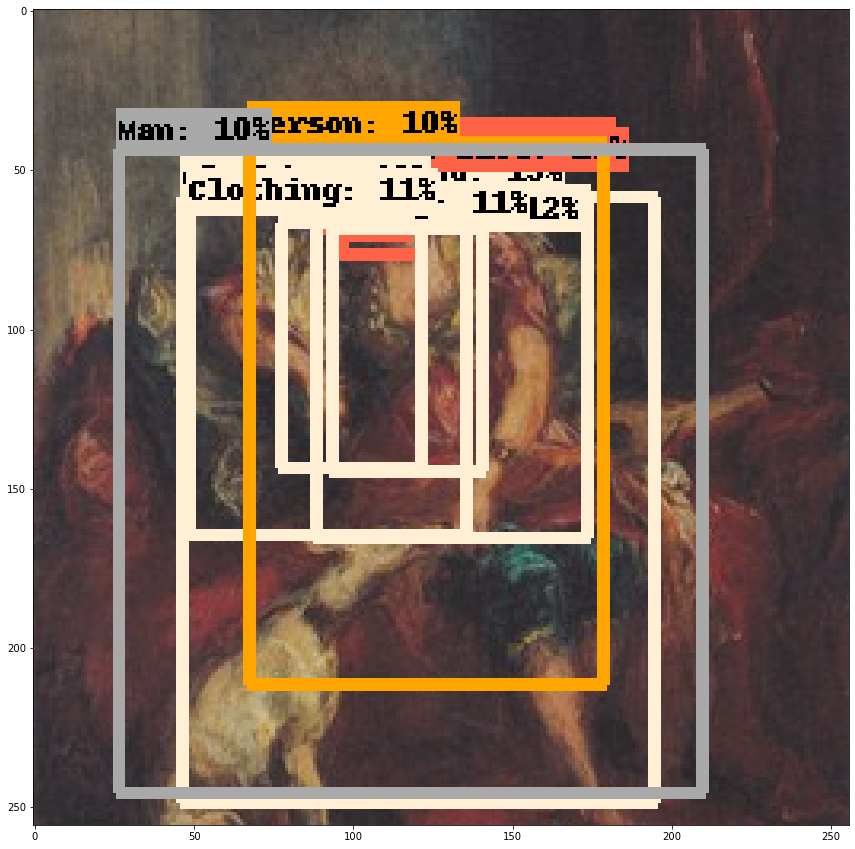

In [14]:

run_detector(detector, resized_image_path )

Found 100 objects.
Inference time:  0.32280707359313965
Font not found, using default font.


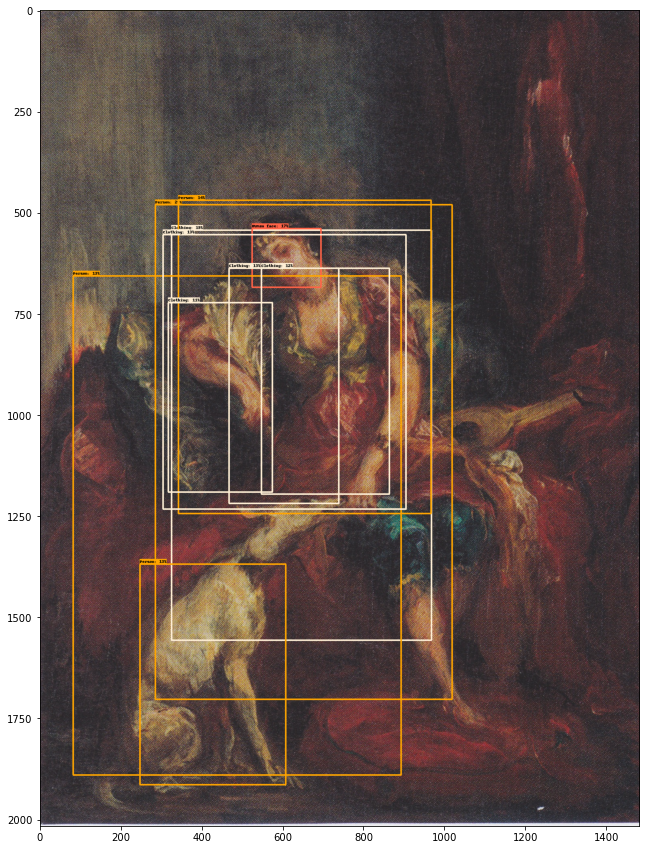

In [15]:
image_with_boxes, result = run_detector(detector, portraits_path.path[0])

In [16]:
image_with_boxes.save("test.jpg", format="JPEG", quality=90)

In [17]:
gresult = None
for i, img_path in enumerate(portraits_path.path[0:15]):
    print(f"\n\niteration {i}\n-----------------")
    image_with_boxes, result = run_detector(detector, img_path, display=False)
    gresult=result
    image_with_boxes.save(images_with_boxes_path.replace("XXX", f"{i}"), format="JPEG", quality=90)



iteration 0
-----------------
Found 100 objects.
Inference time:  0.2637503147125244
Font not found, using default font.


iteration 1
-----------------
Found 100 objects.
Inference time:  0.23969149589538574
Font not found, using default font.


iteration 2
-----------------
Found 100 objects.
Inference time:  0.22871637344360352
Font not found, using default font.


iteration 3
-----------------
Found 100 objects.
Inference time:  0.33722496032714844
Font not found, using default font.


iteration 4
-----------------
Found 100 objects.
Inference time:  0.23915600776672363
Font not found, using default font.


iteration 5
-----------------
Found 100 objects.
Inference time:  0.2357165813446045
Font not found, using default font.


iteration 6
-----------------
Found 100 objects.
Inference time:  0.23243188858032227
Font not found, using default font.


iteration 7
-----------------
Found 100 objects.
Inference time:  0.26780271530151367
Font not found, using default font.


iteratio

In [18]:
gresult.keys()

dict_keys(['detection_class_entities', 'detection_scores', 'detection_boxes', 'detection_class_names', 'detection_class_labels'])

In [ ]:
gresult
result_dtf = pd.DataFrame(gresult)

In [27]:
format_detection_results(gresult)

,detection_class_entities,detection_scores,detection_class_names,detection_class_labels,x0,y0,x1,y1
0,b'Person',0.394036,b'/m/01g317',69,0.086378,0.123166,0.926416,0.734992
1,b'Flowerpot',0.224991,b'/m/0fm3zh',515,0.843366,0.686656,0.967650,0.949363
2,b'Footwear',0.213420,b'/m/09j5n',434,0.884600,0.524943,0.937817,0.659499
3,b'Elephant',0.210114,b'/m/0bwd_0j',448,0.073803,0.092853,0.928495,0.801639
4,b'Footwear',0.192983,b'/m/09j5n',434,0.839856,0.313891,0.891595,0.439595
...,...,...,...,...,...,...,...,...
95,b'Tree',0.083369,b'/m/07j7r',391,0.012224,0.136653,0.569433,0.984222
96,b'Tree',0.083216,b'/m/07j7r',391,0.001968,0.472713,0.073610,0.792093
97,b'Mammal',0.082083,b'/m/04rky',298,0.071949,0.095141,0.927152,0.795164
98,b'Footwear',0.081923,b'/m/09j5n',434,0.776706,0.403415,0.866308,0.493055
